In [123]:
import sys
import random
import matplotlib.pyplot as plt
import numpy as np
import csv

%matplotlib inline

In [124]:
# Given a path to file, load it
# returns data as an array of dictionaries, [{column_name: cell_value}, {...}]

def load_csv(filepath):
    data = []
    with open(filepath) as csvfile:
        reader = csv.DictReader(csvfile, delimiter=",")
        for row in reader:
            data.append(dict(row))
    
    return data

In [125]:
data = load_csv("data/businesses.csv")
data[0]

{'bid': '0',
 'food_class': 'Asian',
 'food_type': 'Japanese',
 'location_x': '2.5312408840758795',
 'location_y': '11.317369500500567',
 'num_reviews': '350'}

In [126]:
column_data_types = {
    "bid": "integer",
    "location_x" : "float",
    "location_y" : "float",
    "num_reviews" : "integer"
}

In [127]:
# Helper class for working with a dataset. It contains helper methods that format and filter the data
class Data:
    # data: [{column_name: cell_value}, ...]
    def __init__(self, data):
        self.data = data
    
    
    # Converts data values to data_types specified in column_defs
    #
    # data: [{column_name: cell_value}, ...]
    # column_defs: {column_name: data_type}
    # returns [{column_name: converted_cell_value}]
    def convert_data_types(self, data, column_defs):
        result = []
        for row in data:
            new_values = {}
            for name, value in row.items():
                if name in column_defs and column_defs[name] == "float":
                    new_values[name] = float(value)
                elif name in column_defs and column_defs[name] == "integer":
                    new_values[name] = int(value)
                else:
                    new_values[name] = value

            result.append(new_values)

        return result

    # Returns only those columns that are specified in column_defs
    #
    # data: [{column_name: cell_value}, ...]
    # column_defs: {column_name: data_type}
    # returns [{selected_column_name: cell_value}]
    def select_columns(self, data, column_defs):
        result = []
        for row in data:
            filtered_values = {}
            for name, value in row.items():
                if name in column_defs:
                    filtered_values[name] = value

            result.append(filtered_values)

        return result
    
    
    # returns location_x/location_y, which we can then use for KMeans
    def kmeans_data(self):
        column_defs = {"location_x": "float", "location_y": "float"}
        selected_data = self.select_columns(self.data, column_defs)
        return self.convert_data_types(selected_data, column_defs)
    
    
    # returns location_x/location_y data in the format suitable for our visualization function
    #
    # returns (List<float>, List<float>)
    def kmeans_data_for_viz(self):
        data = self.kmeans_data()
        x_vals = [r["location_x"] for r in data]
        y_vals = [r["location_y"] for r in data]
        
        return x_vals, y_vals

In [128]:
# Helper function to visualize points in 2d space as a scatter plot
#
# x_vals: List<float>
# y_vals: List<float>
# colors: optional array of colors, must be the same length as x_vals and y_vals.
# more info on matplotlib colors: https://matplotlib.org/2.0.2/api/colors_api.html
def scatter_plot(x_vals, y_vals, colors=None):
    fig = plt.figure(figsize=(20,8))
    ax = fig.add_subplot(1, 1, 1)
    ax.scatter(x_vals, y_vals, c=colors)
    ax.grid(True)
    return fig

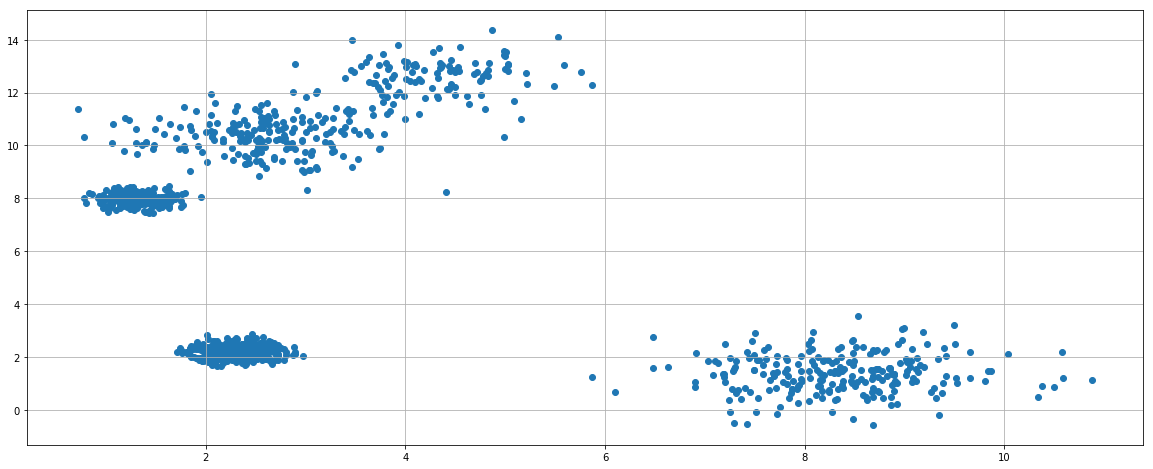

In [129]:
kmeans_data = Data(data)
x_vals, y_vals = kmeans_data.kmeans_data_for_viz()

fig = scatter_plot(x_vals, y_vals)
plt.show()

In [119]:
class KMeans:
    def __init__(self, k, num_iterations=200, tolerance=0.00001):
        self.k = k
        self.num_iterations = num_iterations
        self.tolerance = tolerance
        
        # data: [(x1, y1), (x2, y2)]
        # centers [(center1_x, center1_y), ...]
        # labels [label_1, label_2, ...]
        # where label_i = {0..(k-1)}
        
    def fit(self, data):
        centers = self._initialize_centers(data)
        
        for i in range(self.num_iterations):
            # assign labels
            labels = self._assign_labels(data, centers)
            
            # calculate new cluster centers
            new_centers = self._calculate_cluster_centers(data, labels)
            
            # check if we need to break the loop
            center_diffs = []
            for cluster_id in range(self.k):
                distance_diff = self._distance_between(new_centers[cluster_id], centers[cluster_id])
                center_diffs.append(distance_diff <= self.tolerance)
            
            if all(center_diffs):
                break
            
            centers = new_centers
                
        return centers, labels
        
    
    # data: List<Tuple<float, float>>
    # returns list of center points as a List<Tuple<float, float>>
    def _initialize_centers(self, data):
        centers = []
        # randomly sample k points from data to serve as initial cluster centers
        random_point_idx = random.sample(range(len(data)), self.k)
        centers = [data[idx] for idx in random_point_idx]
        
        return centers
    
    
    # data: List<Tuple<float, float>>
    # centers: List<Tuple<float, float>>
    # returns a list of labels for each point in data as a List<int>, where int value corresponds to cluster_id
    def _assign_labels(self, data, centers):
        labels = []
        
        # implement label assignment
        #
        # for every point in data, find point's nearest cluster center
        # assign each point to its nearest cluster by labelling the point with cluster's id:
        # labels.append(label)
        
        for data_point in data:
            distances_to_clusters = []
            for center_point in centers:
                distance = self._distance_between(data_point, center_point)
                distances_to_clusters.append(distance)
                
            nearest_distance, label = min([(val, idx) for idx, val in enumerate(distances_to_clusters)])
            labels.append(label)
        
        # somewhere, self._distance_between()
        # return [label1_1, label1_2, ...]

        return labels
        
    # calculates distance between 2 points
    # point1: Tuple<float, float>
    # point2: Tuple<float, float>
    # returns float
    def _distance_between(self, point1, point2):
        distance = None
        
        # implement distance calculation
        squared_diff_sum = (point2[0] - point1[0])**2 + (point2[1] - point1[1])**2
        distance = squared_diff_sum ** 0.5
    
        return distance
    
    
    # calculates center of an array of points
    # points: List<Tuple<float, float>> 
    # returns Tuple<float, float>
    def _mean(self, points):
        means = [None, None]
        # implement the rest
        num_dimentions = 2
        sums = [0] * num_dimentions
        for point in points:
            for dim in range(num_dimentions):
                sums[dim] += point[dim]
                
        means = tuple([s / len(points) for s in sums])
    
        return means
    
    
    # calculate cluster centers given data points and its labels
    # data: List<Tuple<float, float>>
    # labels: List<int>
    # returns List<Tuple<float, float>>
    def _calculate_cluster_centers(self, data, labels):
        centers = []
        
        # 1. group points by their label
        # 2. for each cluster, calculate its new center from all points that were assigned to it
        
        cluster_points = {}
        
        for idx, label in enumerate(labels):
            if label not in cluster_points:
                cluster_points[label] = []
            cluster_points[label].append(data[idx])

        for cluster_id, points in cluster_points.items():
            center = self._mean(points)
            centers.append(center)
            
        return centers

In [121]:
# Verify that KMeans works

# since KMeans accepts data as a List<Tuple<float, float>>, 
# we need to convert our x_vals: List<float> and y_vals: List<float> into appropriate format
data_for_kmeans = list(zip(x_vals, y_vals))

# Instantiate Kmeans and run it on data
kmeans = KMeans(2)
centers, labels = kmeans.fit(data_for_kmeans)

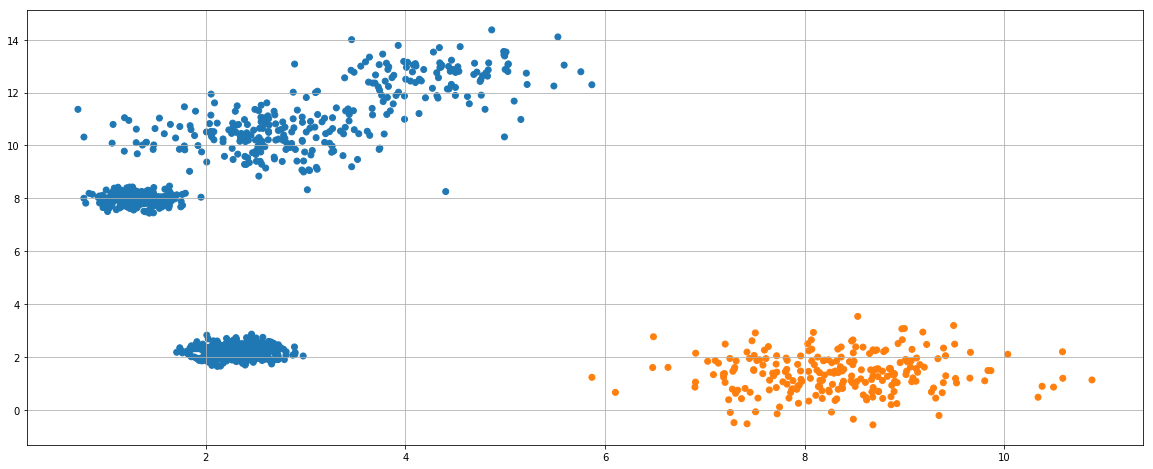

In [122]:
# Visualize clusters

colors = {0: 'tab:blue', 1: 'tab:orange'}
label_colors = [colors[label] for label in labels]
fig = scatter_plot(x_vals, y_vals, label_colors)
plt.show()